# Pajaritos - Birds - Птички 🦜🦉🦩

We will try to use ResNet, which requires images of 224x224.

The reasoning is: the deeper network, the more gradients vanishines, and model performance decreases. E.g. VGG has that disadvantage.
ResNet has a [different architecture](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) where **gradients can flow directly through the skip connections backwards from later layers to initial filters**. 


As for code, major peice of it taken from <https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random

from torchvision import models
import seaborn as sns
from datetime import datetime

from tqdm import tqdm
import pandas as pd

In [2]:
plt.ion()   # interactive mode

### Preparing Data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/birds"

In [4]:
DATA_PATH = "."

In [5]:
# !unzip -oq "/content/drive/MyDrive/Colab Notebooks/birds/valid.zip" -d  "/content/drive/MyDrive/Colab Notebooks/birds/valid/"
# !unzip -oq "/content/drive/MyDrive/Colab Notebooks/birds/test.zip" -d  "/content/drive/MyDrive/Colab Notebooks/birds/test/"
# !unzip -oq "/content/drive/MyDrive/Colab Notebooks/birds/train.zip" -d  "/content/drive/MyDrive/Colab Notebooks/birds/train/"


In [6]:
RESIZE_SIZE = 224, 224

## Normalization

In [7]:
def calculate_mean_std(data_dir: str, dataset_dir: str, size):
    """
    takes a directory containing a dataset and calculate mean and std of dataset's images
    """
    transformation = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])
    
    dataset = datasets.ImageFolder(
        os.path.join(data_dir, dataset_dir),
        transformation
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0
    )
    
    mean, std = 0., 0.
    for images, _ in tqdm(dataloader):
        batch_samples = images.size(0)
        data = images.view(batch_samples, images.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)

    mean /= len(dataloader.dataset)
    std /= len(dataloader.dataset)
    return mean, std



In [8]:
calculate_mean_std(DATA_PATH, "valid", RESIZE_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.57it/s]


(tensor([0.4762, 0.4693, 0.3870]), tensor([0.2035, 0.1980, 0.2020]))

In [9]:
calculate_mean_std(DATA_PATH, "test", RESIZE_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.87it/s]


(tensor([0.4750, 0.4665, 0.3835]), tensor([0.2025, 0.1964, 0.2004]))

In [10]:
calculate_mean_std(DATA_PATH, "train", RESIZE_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████| 913/913 [03:00<00:00,  5.06it/s]


(tensor([0.4704, 0.4669, 0.3898]), tensor([0.2035, 0.2001, 0.2047]))

So we have *mean* and *std* of *train* dataset ^^^ 

## Datasets and Dataloaders

#### Transformations

Having *mean* and *std* we do normalization easily.
Besides, to augment dataset, I apply 
- RandomHorizontalFlip - it's ok to have a bird looking to the right and to the left
- RandomRotation with a small angle, not to have a bird upside down.

In fact, I tested a model with ```RandomRotation(degrees=180)``` and training metrics were worse than validation ones :) It's almost nonsense to have a bird upside-down like a monkey on branch.


In [11]:
norm_mean, norm_std = [0.4704, 0.4669, 0.3898], [0.2035, 0.2001, 0.2047]

data_transforms = {    
    'train': transforms.Compose([
        transforms.Resize(RESIZE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(RESIZE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(RESIZE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ]),
}

#### Datasets


For datasets it's convinient to use [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), very little code required.


As for batch size:
Bigger batches require more memory. With ResNet34 I had a problem when 64-images batch failed with the error:

```
RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 3.95 GiB total capacity; 2.68 GiB already allocated; 145.75 MiB free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation. See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

```
So I used `batch_size=32` all the time.



In [31]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x]) 
    for x in ['train', 'valid', 'test']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True if x == 'train' else False, num_workers=0)
    for x in ['train', 'valid', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [32]:
len(image_datasets["train"]), len(image_datasets["valid"]), len(image_datasets["test"])

(58388, 2000, 2000)

#### Welcome our pajaritos!

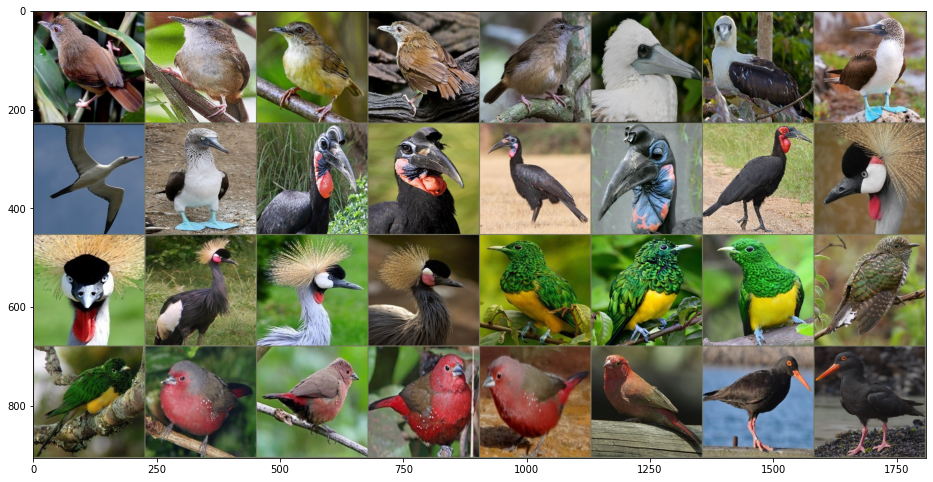

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = norm_std * inp + norm_mean  # denormalize it back
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.rcParams["figure.figsize"] = [16,9]
imshow(out)

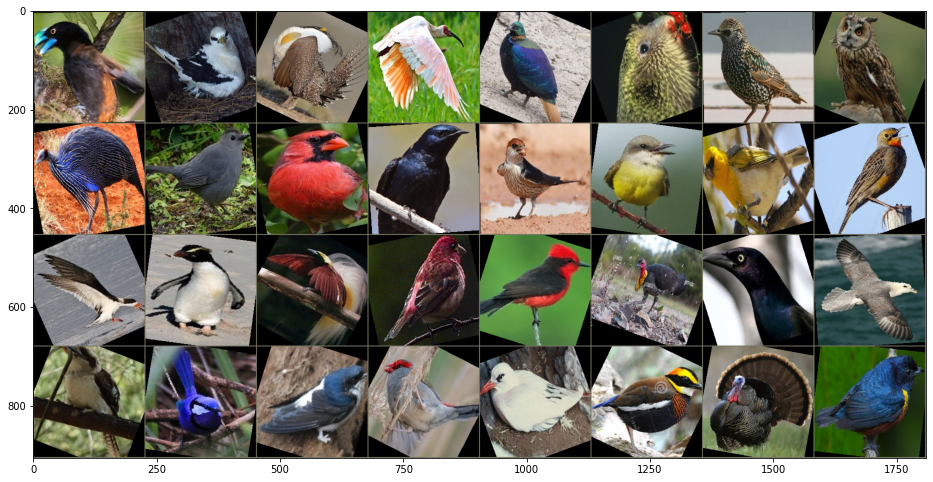

In [15]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

#### How about class balance?

In [16]:
birds_df = pd.read_csv(os.path.join(DATA_PATH, "birds.csv"))
train_birds_df = birds_df[birds_df["data set"] == "train"]

In [17]:
train_birds_df

class index                              filepaths  \
0                0          train/ABBOTTS BABBLER/001.jpg   
1                0          train/ABBOTTS BABBLER/002.jpg   
2                0          train/ABBOTTS BABBLER/003.jpg   
3                0          train/ABBOTTS BABBLER/004.jpg   
4                0          train/ABBOTTS BABBLER/005.jpg   
...            ...                                    ...   
58383          399  train/YELLOW HEADED BLACKBIRD/155.jpg   
58384          399  train/YELLOW HEADED BLACKBIRD/156.jpg   
58385          399  train/YELLOW HEADED BLACKBIRD/157.jpg   
58386          399  train/YELLOW HEADED BLACKBIRD/158.jpg   
58387          399  train/YELLOW HEADED BLACKBIRD/159.jpg   

                        labels data set  
0              ABBOTTS BABBLER    train  
1              ABBOTTS BABBLER    train  
2              ABBOTTS BABBLER    train  
3              ABBOTTS BABBLER    train  
4              ABBOTTS BABBLER    train  
...                        ...      ...  
58383  YELLOW HEADED BLACKBIRD    train  
58384  YELLOW HEADED BLACKBIRD    train  
58385  YELLOW HEADED BLACKBIRD    train  
58386  YELLOW HEADED BLACKBIRD    train  
58387  YELLOW HEADED BLACKBIRD    train  

[58388 rows x 4 columns]

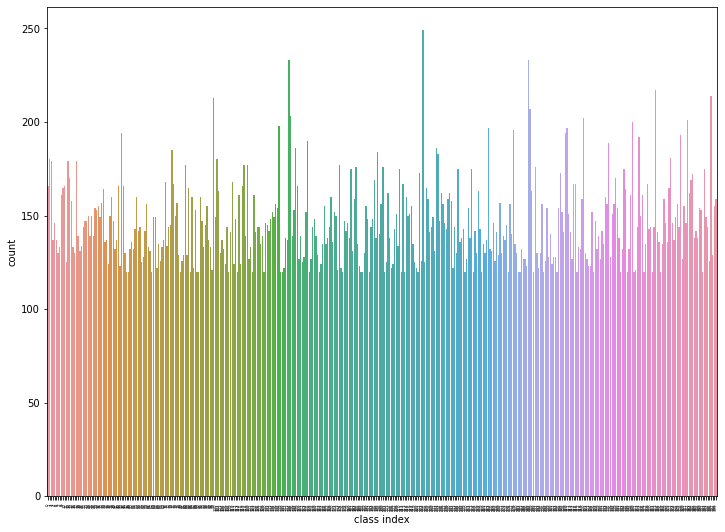

In [18]:
plt.figure(figsize=(12, 9))
sns.countplot(data=train_birds_df, x="class index")
plt.xticks(rotation=90, fontsize=4);

Every class has at least ~125 samples and no greater than 250.
We can consider dataset class-balanced.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DEVICE

'cuda'

## Training functions

Since training takes huge time, I decided to save trained model in a `*.pth` file at each epoch.
So we can choose a model from any epoch later.
`train_model` below does it, and there are functions `load_trained_resnet()` that load a model from `*.pth` files.



In [21]:
def train_model(model, criterion, optimizer, scheduler, model_name, num_epochs=25):
    # this function mostly from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 
    
    loss_metrics = {"train": [], "valid": []}
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            loss_metrics[phase].append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {(time.time() - since)/60:.1f}m')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(DATA_PATH, f"{model_name}-{epoch}.pth"))
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    sns.lineplot(y=loss_metrics["train"], x=range(num_epochs), label="Train")
    sns.lineplot(y=loss_metrics["valid"], x=range(num_epochs), label="Validation")
    plt.show()
    
    return model


In [22]:
def train_and_visualize_model(model, model_name: str, num_epochs: int):
    """
    for given model, model_name and num_epochs creates criterion, optimizer, scheduler and train the model
    """
    
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, model_name, num_epochs=num_epochs)

In [23]:
def test_accuracy(model):
    """
    test_accuracy - calculate accuracy of given model on 'test' dataset
    """
    
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
    
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    

In [24]:
def test_different_images(model, data_path, images_dir):
    """
    load images from 'data_dir' directory, does model inference for given images 
    """  
    
    plt.rcParams["figure.figsize"] = [8,4]
    classes_labels = pd.read_csv(os.path.join(data_path, 'birds latin names.csv'))
    
    dataset = datasets.ImageFolder(
        os.path.join(data_path, images_dir),
        data_transforms['test']
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=32,
        shuffle=True, num_workers=0
    )
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            
            probs = nn.functional.softmax(outputs.data, dim=1)
            top_probs = torch.topk(probs, 3)
            for pred_labels, values, input_image in zip(top_probs.indices, top_probs.values, inputs):
                for pred_label, pred_value in zip(pred_labels, values):
                    print(f"{pred_value.item()*100.0:.3f}% {classes_labels.iloc[pred_label.item()]['class']}")
                print()
                imshow(input_image.cpu())


## RestNet18

OK, we are ready to train ResNet18


In [25]:
models.resnet18(pretrained=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
len(list(models.resnet18(pretrained=False).parameters()))

62

ResNet18 has 62 layers and the only FC layer, so I change it to have 400 out features.


I've also tried freezing some parameters of the network, to prevent convolutional layer from learning, for this I've added `active_params` argument, this is a number of last layers which will require gradient.

In [27]:
def create_resnet18(pretrained: bool, active_params: int = 0):
    resnet18 = models.resnet18(pretrained=pretrained)
    
    # freezing big portion of the model
    for param in list(resnet18.parameters())[:-active_params]:
        param.requires_grad = False
    
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 400)
    return resnet18.to(device)
    

In [28]:
def load_trained_resnet18(epoch: int):
    resnet18 = create_resnet18(pretrained=False)
        
    resnet_11_model = torch.load(f'ResNet18-{epoch}.pth')
    
    resnet18.load_state_dict(resnet_11_model['model_state_dict'])
    resnet18.eval()
    return resnet18

Let's train ResNet18 for 25 epochs

Epoch 0/24
----------
train Loss: 3.6058 Acc: 0.4088 Time: 2.6m
valid Loss: 1.3524 Acc: 0.8065 Time: 2.6m

Epoch 1/24
----------
train Loss: 1.2785 Acc: 0.7989 Time: 5.1m
valid Loss: 0.5808 Acc: 0.9210 Time: 5.2m

Epoch 2/24
----------
train Loss: 0.7398 Acc: 0.8716 Time: 7.7m
valid Loss: 0.3510 Acc: 0.9430 Time: 7.8m

Epoch 3/24
----------
train Loss: 0.5303 Acc: 0.9021 Time: 10.4m
valid Loss: 0.2521 Acc: 0.9550 Time: 10.4m

Epoch 4/24
----------
train Loss: 0.4143 Acc: 0.9224 Time: 12.9m
valid Loss: 0.2022 Acc: 0.9665 Time: 13.0m

Epoch 5/24
----------
train Loss: 0.3408 Acc: 0.9353 Time: 15.6m
valid Loss: 0.1603 Acc: 0.9690 Time: 15.6m

Epoch 6/24
----------
train Loss: 0.2850 Acc: 0.9462 Time: 18.2m
valid Loss: 0.1480 Acc: 0.9720 Time: 18.2m

Epoch 7/24
----------
train Loss: 0.2336 Acc: 0.9587 Time: 20.8m
valid Loss: 0.1358 Acc: 0.9775 Time: 20.8m

Epoch 8/24
----------
train Loss: 0.2233 Acc: 0.9604 Time: 23.4m
valid Loss: 0.1363 Acc: 0.9750 Time: 23.5m

Epoch 9/24
----------
tra

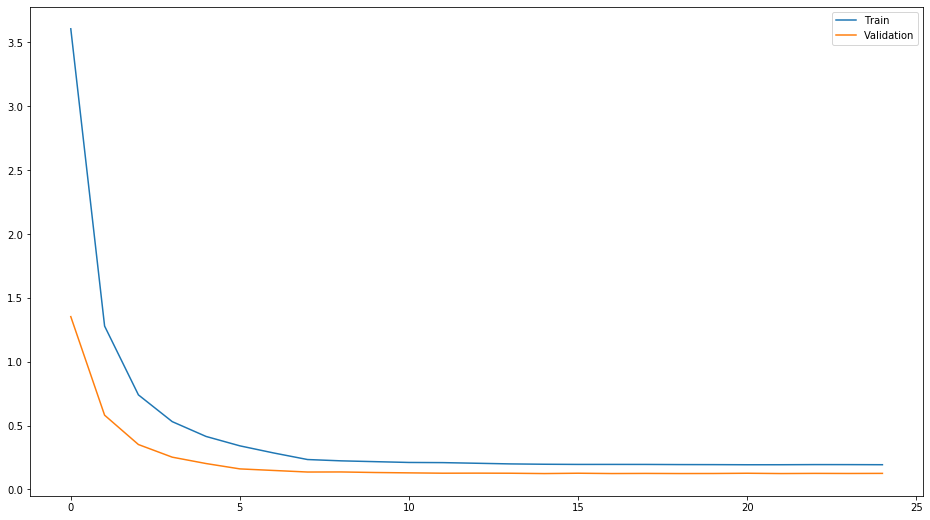

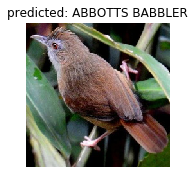

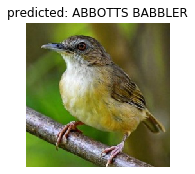

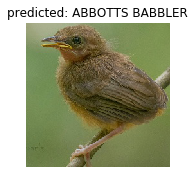

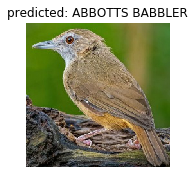

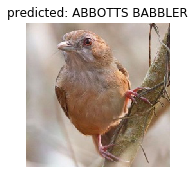

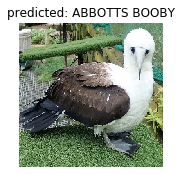

CPU times: user 6h 1min 39s, sys: 20.2 s, total: 6h 1min 59s
Wall time: 1h 5min 7s


In [63]:
%%time
resnet18 = create_resnet18(pretrained=True)

train_and_visualize_model(resnet18, model_name='ResNet18', num_epochs=25)

del resnet18
torch.cuda.empty_cache()

From this training session we can see:
1. loss on **validation** dataset is less than on **train** one, for example 0.12 vs 0.19 correspondingly on Epoch 16 
2. accuracy on **validation** dataset is greater than on **train**, for example  0.98 vs 0.97 correspondingly, so model is a bit underfitted, we may give it a go on a dozens epochs.

The best epoch here was 16, so let's load it from the file and calculate its accuracy on **test** dataset: 

In [29]:
resnet18 = load_trained_resnet18(epoch=16)

In [33]:
test_accuracy(resnet18)

Test Loss: 0.0991 Acc: 0.9870


test accuracy is quite good, how about predictions for some tricky images?

99.729% AFRICAN CROWNED CRANE
0.071% VULTURINE GUINEAFOWL
0.028% DEMOISELLE CRANE



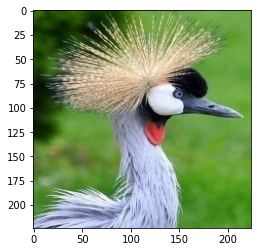

46.603% BARROWS GOLDENEYE
11.234% HOODED MERGANSER
7.961% LONG-EARED OWL



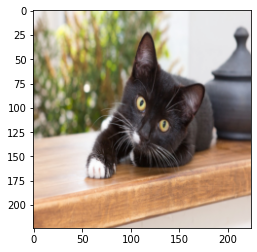

98.061% AFRICAN CROWNED CRANE
0.122% KING VULTURE
0.121% JABIRU



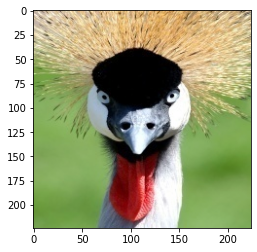

99.670% AFRICAN CROWNED CRANE
0.113% SANDHILL CRANE
0.050% JABIRU



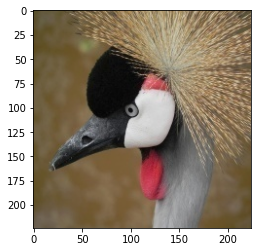

99.824% AFRICAN CROWNED CRANE
0.079% KIWI
0.021% ANHINGA



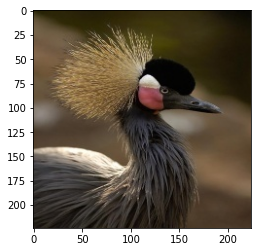

31.849% LONG-EARED OWL
11.830% SNOWY OWL
6.370% GREAT GRAY OWL



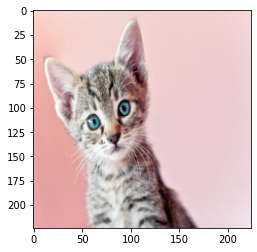

82.367% LONG-EARED OWL
3.691% STRIPED OWL
2.314% GREAT POTOO



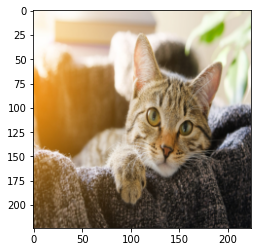

99.731% AFRICAN CROWNED CRANE
0.033% ANHINGA
0.016% HORNED GUAN



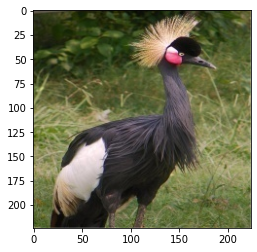

97.900% ANTBIRD
1.018% BARRED PUFFBIRD
0.061% HOATZIN



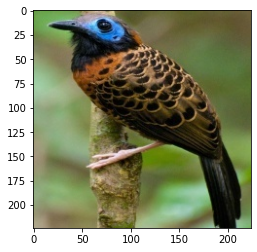

38.537% LONG-EARED OWL
24.334% SNOWY OWL
3.572% VICTORIA CROWNED PIGEON



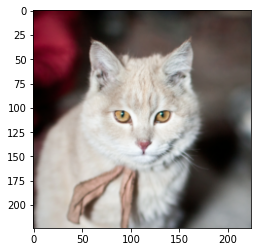

91.340% AFRICAN FIREFINCH
4.048% RUDY KINGFISHER
0.618% APAPANE



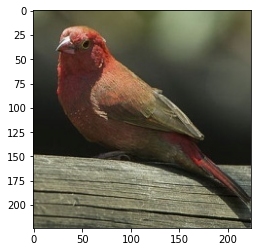

56.545% LONG-EARED OWL
7.808% GRAY PARTRIDGE
4.702% GREAT POTOO



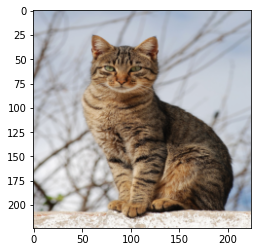

In [34]:
test_different_images(resnet18, DATA_PATH, "images-to-test")

We have 82.4% LONG-EARED OWL for a cat :)
That cat is a real owl, look at its eyes, ears and colourings.
Other cats have less than 50% probabilities, but to solve this problem we need to train our model on non-bird images too.


#### ResNet18 with 30 active layers instead of 62

Epoch 0/19
----------
train Loss: 3.6679 Acc: 0.3957 Time: 1.8m
valid Loss: 1.4218 Acc: 0.8030 Time: 1.9m

Epoch 1/19
----------
train Loss: 1.3495 Acc: 0.7876 Time: 3.7m
valid Loss: 0.6286 Acc: 0.9040 Time: 3.7m

Epoch 2/19
----------
train Loss: 0.7978 Acc: 0.8611 Time: 5.6m
valid Loss: 0.3997 Acc: 0.9300 Time: 5.6m

Epoch 3/19
----------
train Loss: 0.5783 Acc: 0.8944 Time: 7.4m
valid Loss: 0.2884 Acc: 0.9495 Time: 7.5m

Epoch 4/19
----------
train Loss: 0.4554 Acc: 0.9141 Time: 9.3m
valid Loss: 0.2270 Acc: 0.9560 Time: 9.3m

Epoch 5/19
----------
train Loss: 0.3775 Acc: 0.9280 Time: 11.2m
valid Loss: 0.1912 Acc: 0.9625 Time: 11.2m

Epoch 6/19
----------
train Loss: 0.3201 Acc: 0.9383 Time: 13.1m
valid Loss: 0.1686 Acc: 0.9675 Time: 13.1m

Epoch 7/19
----------
train Loss: 0.2700 Acc: 0.9515 Time: 14.9m
valid Loss: 0.1631 Acc: 0.9685 Time: 15.0m

Epoch 8/19
----------
train Loss: 0.2609 Acc: 0.9531 Time: 16.8m
valid Loss: 0.1571 Acc: 0.9700 Time: 16.9m

Epoch 9/19
----------
train L

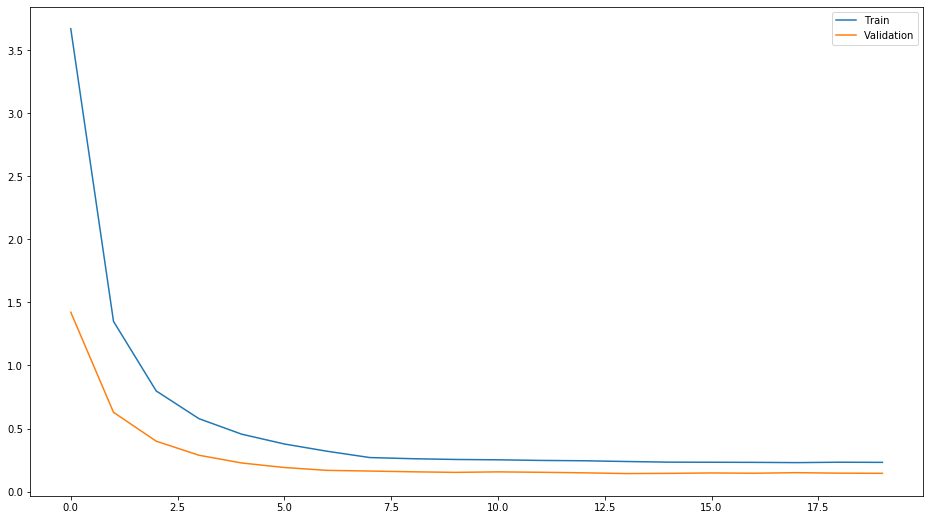

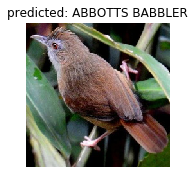

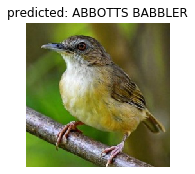

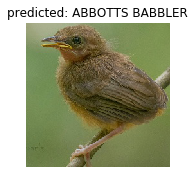

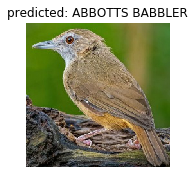

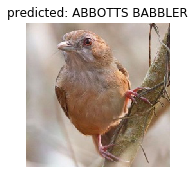

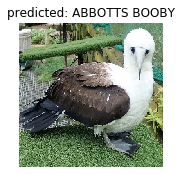

CPU times: user 4h 35min 50s, sys: 16.1 s, total: 4h 36min 6s
Wall time: 37min 32s


In [88]:
%%time
resnet18 = create_resnet18(pretrained=True, active_params=30)

train_and_visualize_model(resnet18, model_name='ResNet18-30active', num_epochs=20)

del resnet18
torch.cuda.empty_cache()

Comparing these two learnings (with all layers requiring grad and with half of them frozen), I can say that
- loss is greater for half-frozen network (because error surface is different, less variables, right?)
- accuracy is almost the same (?)
- trainning time is 50% less for half-frozen network (less gradients to calculate)

## ResNet34

In [28]:
models.resnet34(pretrained=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [79]:
def create_resnet34(pretrained, active_params=0):
    resnet34 = models.resnet34(pretrained=pretrained)
    
    # freezing big portion of the model
    for param in list(resnet34.parameters())[:-active_params]:
        param.requires_grad = False
    
    num_ftrs = resnet34.fc.in_features
    resnet34.fc = nn.Linear(num_ftrs, 400)
    return resnet34.to(device)
    

In [30]:
del resnet18
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/sim/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 0/34
----------
train Loss: 3.0490 Acc: 0.4980 Time: 3.5m
valid Loss: 0.8273 Acc: 0.8815 Time: 3.6m

Epoch 1/34
----------
train Loss: 0.8314 Acc: 0.8603 Time: 7.1m
valid Loss: 0.3193 Acc: 0.9480 Time: 7.1m

Epoch 2/34
----------
train Loss: 0.4668 Acc: 0.9127 Time: 10.7m
valid Loss: 0.2141 Acc: 0.9605 Time: 10.7m

Epoch 3/34
----------
train Loss: 0.3311 Acc: 0.9368 Time: 14.2m
valid Loss: 0.1623 Acc: 0.9680 Time: 14.3m

Epoch 4/34
----------
train Loss: 0.2542 Acc: 0.9497 Time: 17.8m
valid Loss: 0.1365 Acc: 0.9685 Time: 17.8m

Epoch 5/34
----------
train Loss: 0.2042 Acc: 0.9596 Time: 21.4m
valid Loss: 0.1129 Acc: 0.9750 Time: 21.4m

Epoch 6/34
----------
train Loss: 0.1656 Acc: 0.9673 Time: 24.9m
valid Loss: 0.1053 Acc: 0.9765 Time: 25.0m

Epoch 7/34
----------
train Loss: 0.1263 Acc: 0.9771 Time: 28.5m
valid Loss: 0.0934 Acc: 0.9790 Time: 28.5m

Epoch 8/34
----------
train Loss: 0.1161 Acc: 0.9799 Time: 32.1m
valid Loss: 0.0864 Acc: 0.9805 Time: 32.1m

Epoch 9/34
----------
t

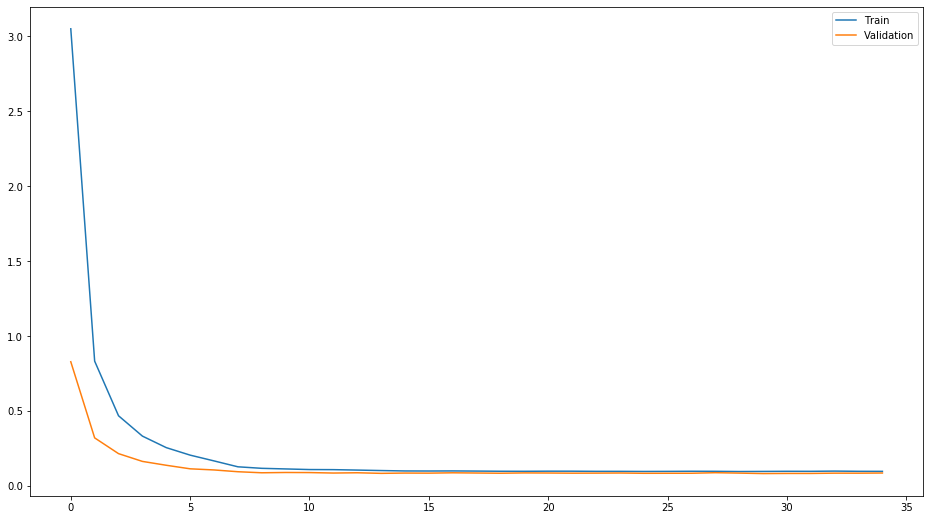

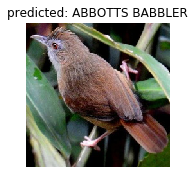

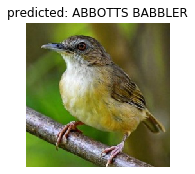

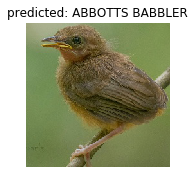

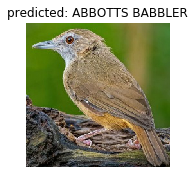

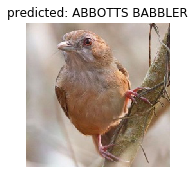

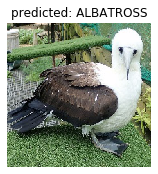

CPU times: user 9h 1min 4s, sys: 28.2 s, total: 9h 1min 33s
Wall time: 2h 5min 5s


In [65]:
%%time
resnet34 = create_resnet34(pretrained=True)

train_and_visualize_model(resnet34, 'ResNet34', num_epochs=35)

del resnet34
torch.cuda.empty_cache()

### ResNet34 with frozen params (only last 10 are active)

Epoch 0/19
----------
train Loss: 4.1072 Acc: 0.3168 Time: 1.9m
valid Loss: 2.1606 Acc: 0.6770 Time: 2.0m

Epoch 1/19
----------
train Loss: 1.9196 Acc: 0.6932 Time: 3.9m
valid Loss: 1.1056 Acc: 0.8300 Time: 4.0m

Epoch 2/19
----------
train Loss: 1.2480 Acc: 0.7790 Time: 5.9m
valid Loss: 0.7126 Acc: 0.8765 Time: 5.9m

Epoch 3/19
----------
train Loss: 0.9666 Acc: 0.8143 Time: 7.9m
valid Loss: 0.5446 Acc: 0.9040 Time: 7.9m

Epoch 4/19
----------
train Loss: 0.8047 Acc: 0.8384 Time: 9.9m
valid Loss: 0.4491 Acc: 0.9200 Time: 9.9m

Epoch 5/19
----------
train Loss: 0.6987 Acc: 0.8557 Time: 11.8m
valid Loss: 0.3930 Acc: 0.9260 Time: 11.9m

Epoch 6/19
----------
train Loss: 0.6236 Acc: 0.8696 Time: 13.8m
valid Loss: 0.3479 Acc: 0.9245 Time: 13.9m

Epoch 7/19
----------
train Loss: 0.5669 Acc: 0.8828 Time: 15.8m
valid Loss: 0.3283 Acc: 0.9360 Time: 15.9m

Epoch 8/19
----------
train Loss: 0.5550 Acc: 0.8846 Time: 17.8m
valid Loss: 0.3269 Acc: 0.9385 Time: 17.9m

Epoch 9/19
----------
train L

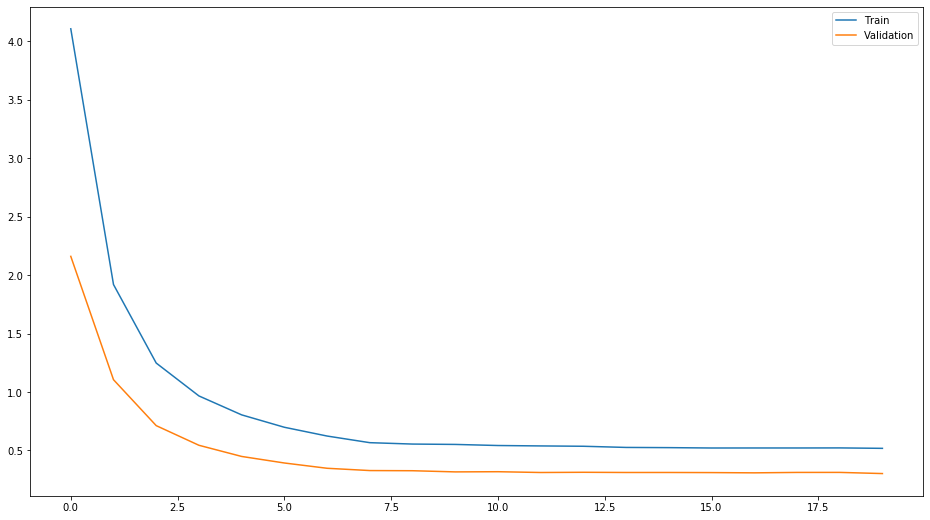

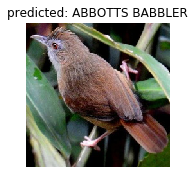

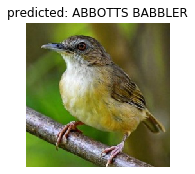

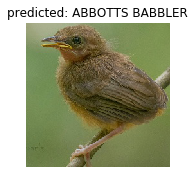

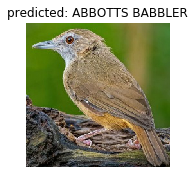

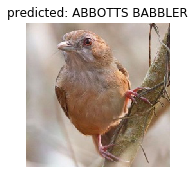

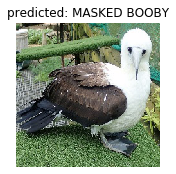

CPU times: user 4h 36min 44s, sys: 16.1 s, total: 4h 37min
Wall time: 39min 50s


In [77]:
%%time
resnet34 = create_resnet34(pretrained=True)

train_and_visualize_model(resnet34, 'ResNet34-frozen', num_epochs=20)

del resnet34
torch.cuda.empty_cache()

### ResNet34 with frozen params (30 active)

Epoch 0/19
----------
train Loss: 3.3463 Acc: 0.4439 Time: 2.2m
valid Loss: 1.0732 Acc: 0.8440 Time: 2.2m

Epoch 1/19
----------
train Loss: 1.0683 Acc: 0.8131 Time: 4.4m
valid Loss: 0.4344 Acc: 0.9260 Time: 4.5m

Epoch 2/19
----------
train Loss: 0.6335 Acc: 0.8762 Time: 6.6m
valid Loss: 0.2788 Acc: 0.9500 Time: 6.7m

Epoch 3/19
----------
train Loss: 0.4588 Acc: 0.9059 Time: 8.9m
valid Loss: 0.2016 Acc: 0.9635 Time: 8.9m

Epoch 4/19
----------
train Loss: 0.3644 Acc: 0.9235 Time: 11.1m
valid Loss: 0.1632 Acc: 0.9685 Time: 11.2m

Epoch 5/19
----------
train Loss: 0.3001 Acc: 0.9370 Time: 13.3m
valid Loss: 0.1387 Acc: 0.9720 Time: 13.4m

Epoch 6/19
----------
train Loss: 0.2546 Acc: 0.9461 Time: 15.5m
valid Loss: 0.1242 Acc: 0.9730 Time: 15.6m

Epoch 7/19
----------
train Loss: 0.2059 Acc: 0.9585 Time: 17.8m
valid Loss: 0.1167 Acc: 0.9735 Time: 17.8m

Epoch 8/19
----------
train Loss: 0.1950 Acc: 0.9617 Time: 20.0m
valid Loss: 0.1148 Acc: 0.9735 Time: 20.1m

Epoch 9/19
----------
train

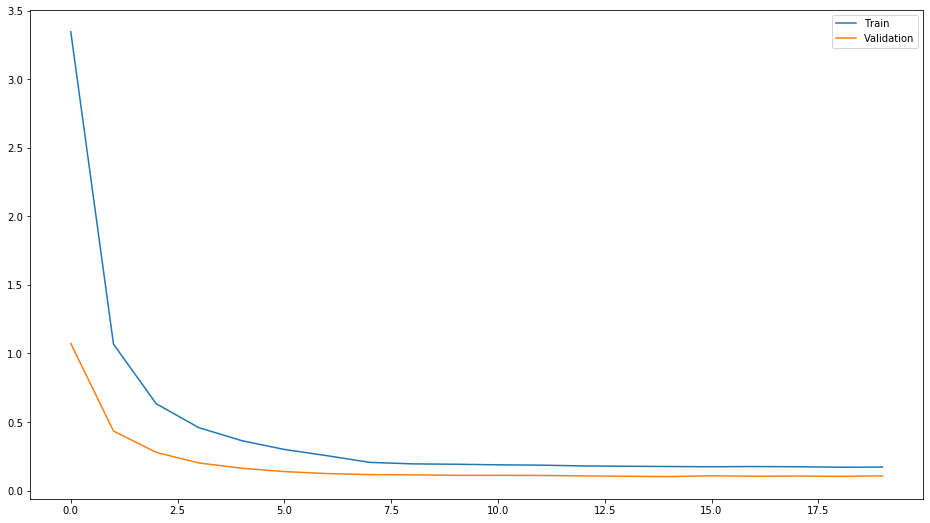

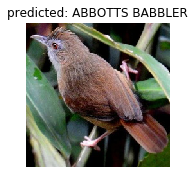

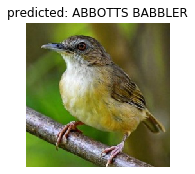

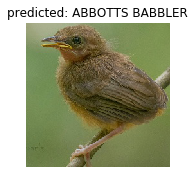

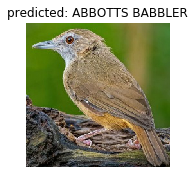

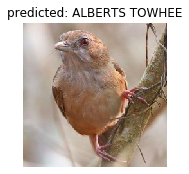

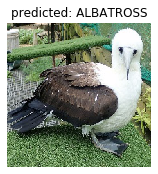

CPU times: user 4h 41min 25s, sys: 16.3 s, total: 4h 41min 42s
Wall time: 44min 33s


In [80]:
%%time
resnet34 = create_resnet34(pretrained=True, active_params=30)

train_and_visualize_model(resnet34, 'ResNet34-30-active', num_epochs=20)

del resnet34
torch.cuda.empty_cache()

10 active layers worked not very good, accuracy was about 0.30
But with 30 active layers we have better results and also shorter training time.

## Telegram Bot

some code snippets to use inside the bot

In [90]:
file_path = 'images-to-test/CAT/001.jpeg'
image = torchvision.io.read_image(file_path)

In [33]:
trs = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(RESIZE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])

In [34]:
image = trs(image)

In [36]:
image.unsqueeze(dim=0).shape

torch.Size([1, 3, 224, 224])

In [43]:
def classify(model, data_path, image_file_path):
    
    classes_labels = pd.read_csv(os.path.join(data_path, 'birds latin names.csv'))
    
    trs = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(RESIZE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])
    
    image = torchvision.io.read_image(file_path)
    image = trs(image)
    
    inputs = image.unsqueeze(dim=0).to(device)
    model.eval()
    res = []
    with torch.no_grad():
        outputs = model(inputs)
            
        probs = nn.functional.softmax(outputs.data, dim=1)
        top_probs = torch.topk(probs, 3)
        for pred_labels, values, input_image in zip(top_probs.indices, top_probs.values, inputs):
            for pred_label, pred_value in zip(pred_labels, values):
                res.append(f"{pred_value.item()*100.0:.3f}% {classes_labels.iloc[pred_label.item()]['class']}")
            
            imshow(input_image.cpu())
    return res

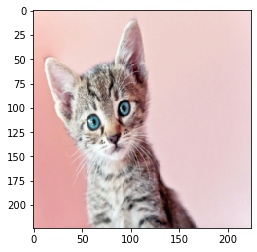

['46.569% LONG-EARED OWL', '11.233% STRIPED OWL', '5.060% BARRED PUFFBIRD']

In [44]:
classify(resnet18, DATA_PATH, file_path)